In [5]:
# !pip install transformers==4.43.4
# !pip install torch
# # !pip install trl
# !pip install trl==0.11
# !pip install peft
# !pip install --upgrade tqdm
# !pip install -U bitsandbytes
# !pip install --upgrade jinja2

In [6]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig
from trl import SFTTrainer

In [7]:
from prepare_data import get_sft_datasets

In [8]:
train_dataset, test_dataset = get_sft_datasets(dataset_name='my-local-dataset/')

Loading and processing dataset
Dataset split into 31485 training examples and 1658 testing examples.
Dataset processing complete.


In [5]:
print("\n--- Train Set Verification ---")
print(f"Train dataset size: {len(train_dataset)} examples")
print("Features:", train_dataset.features)
print("\nPROMPT:", train_dataset[0]['prompt'])
print("COMPLETION:", train_dataset[0]['completion'])
    
print("\n--- Test Set Verification ---")
print(f"Test dataset size: {len(test_dataset)} examples")
print("Features:", test_dataset.features)
print("\nPROMPT:", test_dataset[0]['prompt'])
print("COMPLETION:", test_dataset[0]['completion'])


--- Train Set Verification ---
Train dataset size: 31485 examples
Features: {'prompt': Value(dtype='string', id=None), 'completion': Value(dtype='string', id=None)}

PROMPT: ### Instruction:
What are some tips for developing a better mental attitude towards difficult tasks.

### Response:

COMPLETION: Break difficult tasks down into manageable pieces. 
2. Take things one step at a time and reward yourself for small accomplishments. 
3. Visualize yourself succeeding in the task. 
4. Focus on the process rather than the outcome. 
5. Remind yourself that you are capable of completing the task.
6. Believe in yourself and your ability to find new solutions to problems. 
7. Give yourself positive affirmations and build a positive mindset.
8. Eliminate distractions and prioritize meaningful tasks. 
9. Take time to refocus and regroup when necessary. 
10. Surround yourself with positive people who will help you stay focused on your goals.

--- Test Set Verification ---
Test dataset size: 1658

In [6]:
train_dataset

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 31485
})

In [7]:
test_dataset

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 1658
})

In [8]:
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU count: 1
GPU name: NVIDIA A10G


In [9]:
# Model and tokenizer names
model_name = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token 

In [10]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

In [11]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.config.use_cache = False # Disable caching for training

In [12]:
lora_config = LoraConfig(
    r=16,                
    lora_alpha=32,       
    target_modules=["c_attn"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

In [13]:
training_args = TrainingArguments(
    output_dir="./sft_results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    learning_rate=2e-4,
    fp16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    logging_steps=50,
    logging_first_step=True,
    eval_strategy="steps",      
    eval_steps=500,             
    save_steps=500,             
    save_total_limit=2,         
    load_best_model_at_end=True
)

In [14]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=lora_config,
    tokenizer=tokenizer,
    args=training_args,
    max_seq_length=1024,
)

##  Start training

In [15]:
trainer.train()

Step,Training Loss,Validation Loss
500,2.132800,2.020864
1000,2.110600,1.962985
1500,2.083500,1.935814
2000,2.057300,1.916776
2500,2.042000,1.903975
3000,2.015600,1.889812
3500,2.015000,1.881979
4000,2.003500,1.874724
4500,1.987200,1.868824
5000,1.995500,1.863858


TrainOutput(global_step=5904, training_loss=2.0524148342974464, metrics={'train_runtime': 1224.7351, 'train_samples_per_second': 77.123, 'train_steps_per_second': 4.821, 'total_flos': 8489488484100096.0, 'train_loss': 2.0524148342974464, 'epoch': 3.0})

In [17]:
trainer.save_model("./peft_sft_final_checkpoint")
tokenizer.save_pretrained("./peft_sft_final_checkpoint")

('./peft_sft_final_checkpoint/tokenizer_config.json',
 './peft_sft_final_checkpoint/special_tokens_map.json',
 './peft_sft_final_checkpoint/vocab.json',
 './peft_sft_final_checkpoint/merges.txt',
 './peft_sft_final_checkpoint/added_tokens.json',
 './peft_sft_final_checkpoint/tokenizer.json')

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\nLoading base gpt2 model...")
base_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
base_tokenizer = AutoTokenizer.from_pretrained("gpt2")

print("Loading PEFT fine-tuned SFT model...")
sft_model = AutoModelForCausalLM.from_pretrained("./peft_sft_final_checkpoint").to(device)
sft_tokenizer = AutoTokenizer.from_pretrained("./peft_sft_final_checkpoint")


Loading base gpt2 model...
Loading PEFT fine-tuned SFT model...


In [10]:
def generate_response(model, tokenizer, prompt_text):
    """
    Generates a response from a given model and tokenizer.
    """
    
    formatted_prompt = f"### Instruction:\n{prompt_text}\n\n### Response:\n"
    
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=200,
            temperature=0.7,  
            do_sample=True, 
        )
    
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return full_response[len(formatted_prompt):].strip()

In [13]:
test_dataset

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 1658
})

In [14]:
def evaluate_models(prompt, ground_truth, models):
    print("\n" + "="*60)
    print(" PERFORMANCE COMPARISON ".center(60, "="))
    print("="*60)

    print(f"\nPROMPT:\n{prompt}\n")
    print(f"GROUND TRUTH:\n{ground_truth}\n")

    for name, model, tokenizer in models:
        print(f"\n--- {name.upper()} RESPONSE ---")
        response = generate_response(model, tokenizer, prompt)
        print(response)

    print("\n" + "="*60)

models_to_compare = [
    ("Base Model (GPT-2)", base_model, base_tokenizer),
    ("PEFT SFT Model", sft_model, sft_tokenizer),
]

In [15]:
idx = 20
prompt = test_dataset[idx]["prompt"]
ground_truth = test_dataset[idx]["completion"]


evaluate_models(prompt, ground_truth, models_to_compare)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



================== PERFORMANCE COMPARISON ==================

PROMPT:
### Instruction:
I want to shop for a new car. What should I look for in price, features, and safety.

### Response:


GROUND TRUTH:
For price, look for a car that fits your budget. Consider the total cost, including maintenance, registration, and insurance. When it comes to features, think about what is most important to you. Do you need a lot of cargo space? Or are you looking for the latest technology? When it comes to safety, look for a car with the latest safety features, like lane-keeping assist, adaptive cruise control, and blind spot monitoring. Additionally, consider the car’s ratings in crash tests and look for features like airbags, anti-lock brakes, and anti-theft systems.


--- BASE MODEL (GPT-2) RESPONSE ---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


It's just me trying to get a car that looks nice, feels like it has fun, and can drive well enough.

### Response:


### Response:

I have a new car, but it has a couple things I need to do to make it fit.

### Response:


### Response:


### Response:

I have a new car, but it has a couple things I need to do to make it fit.

### Response:


### Response:


### Response:

I have a new car, but it has a couple things I need to do to make it fit.

### Response:


### Response:


### Response:


### Response:


### Response:


### Response:


### Response:


### Response:


### Response:


### Response:


### Response:


### Response:


### Response:

--- PEFT SFT MODEL RESPONSE ---
Some other factors you may consider in price, features, and safety include performance, environmental, and safety. This can include the size of the car and the type of warranty you are seeking. Additionally, you may need to know the type of vehicle you are looking for. Additionally, you may want to look into 

In [23]:
import json
import matplotlib.pyplot as plt

log_file = "sft_results/checkpoint-5904/trainer_state.json"

# Read the log file
with open(log_file, 'r') as f:
    logs = json.load(f)

# --- Prepare lists to store all metrics ---
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []

# --- Iterate through the log history and extract all data ---
for log in logs["log_history"]:
    if "loss" in log:
        train_steps.append(log["step"])
        train_losses.append(log["loss"])
    
    elif "eval_loss" in log:
        eval_steps.append(log["step"])
        eval_losses.append(log["eval_loss"])

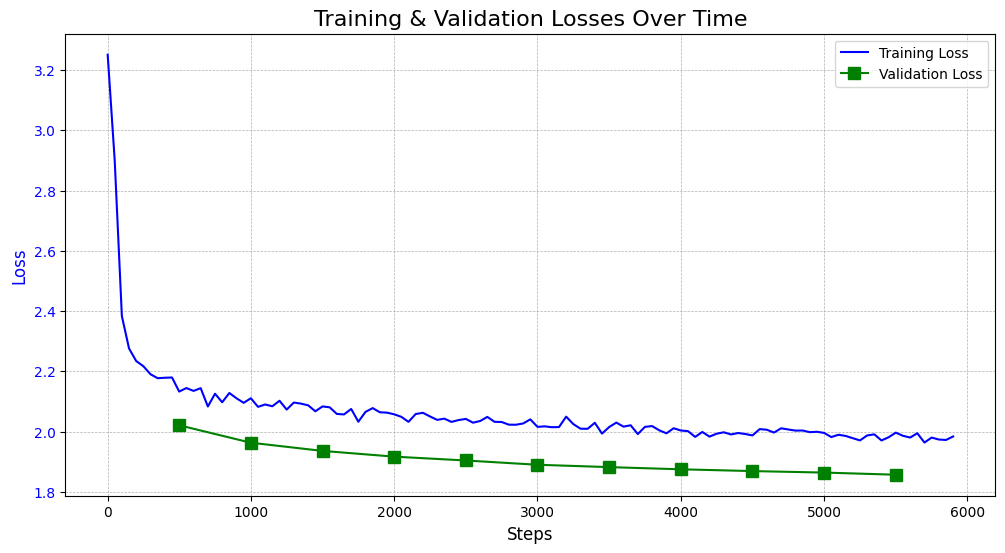

In [25]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(train_steps, train_losses, 'b-', label="Training Loss")
ax1.plot(eval_steps, eval_losses, 'g-s', label="Validation Loss", markersize=8) 
ax1.set_xlabel("Steps", fontsize=12)
ax1.set_ylabel("Loss", color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.title("Training & Validation Losses Over Time", fontsize=16)

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper right')

plt.show()